In [1]:
import numpy as np 
import matplotlib.pyplot  as plt
import random
import time
%matplotlib inline

In [2]:
def loadDataSet(fileName):
    """
    加载数据
    """
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return np.array(dataMat) , np.array(labelMat)

def selectJrand(i,m):
    """
    选择下标
    """
    j=i
    while(j==i):
        j = int(random.uniform(0,m)) #范围随机数
    return j

def clipAlpha(aj,H,L):
    """
    调整aj大小
    """
    if aj > H:
        aj = H 
    if aj < L:
        aj = L
    return aj 

In [3]:
datafile = "testSet.txt"

In [4]:
X_data , y_data = loadDataSet(datafile)

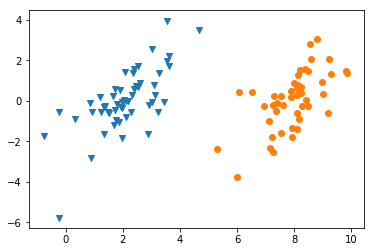

In [5]:
x1s = []
y1s = []
x2s = []
y2s = []

for index in range(len(y_data)):
    if y_data[index] == -1:
        x1s.append(X_data[index][0])
        y1s.append(X_data[index][1])
    if y_data[index] == 1:
        x2s.append(X_data[index][0])
        y2s.append(X_data[index][1])
plt.scatter(x1s,y1s,marker="v")
plt.scatter(x2s,y2s,marker="o")
plt.show()

In [6]:
class svm(object):
    
    def __init__(self):
        self.alphas = None
        self.b = None
        
    def smoSimple(self,X_train,y_train,C,toler,maxIter):
        """
        @ X_train : 训练集
        @ y_train ： label
        @ C : 常数C
        @ toler : 容错率
        @ maxIter : 最大训练次数
        """
        train_num , dim = X_train.shape
        
        if self.alphas == None :
            self.alphas = np.zeros(train_num) 
            
        if self.b == None :
            self.b = 0
        
        #support_vectors = None 
        #support_labels = None 
        step = 0
        time_star = time.time()
        while step < maxIter:
            alphaPairsChanged = 0
            for index in range(train_num):
                temp = np.array([y_train[i]*self.alphas[i]*X_train[i] for i in range(len(y_train))])
                print temp.shape
                fxi = np.sum(np.dot(X_train[index].T,np.array([y_train[i]*self.alphas[i]*X_train[i] for i in range(len(y_train))]).T)) + self.b
                errori = fxi - y_train[index]
                #############################################################################################################################
                # 需要 alpha < C 的时候为 软间隔加入的情况。                                                                                     #
                # 注意这里的符号问题   例子：本来标签应该是1的结果label里是-1，那么error = 预测出来的（1） - 本来的label（-1） = 2 -> label * error = -2 #
                # 这里是要让误差大的参与训练                                                                                                    #
                if ((y_train[index] * errori < -toler) and (self.alphas[index] < C)) or \
                    ((y_train[index] * errori > toler) and (self.alphas[index] > 0)):
                    #选择 aj
                    j = selectJrand(index,train_num)
                    fxj =  np.sum(np.dot(X_train[j].T,np.array([y_train[i]*self.alphas[i]*X_train[i] for i in range(len(y_train))]).T)) + self.b
                    
                    errorj = fxj - y_train[j]
                    # 用于比较，使用copy防止引用随着改
                    alphaIold = self.alphas[index].copy()
                    alphaJold = self.alphas[j].copy()
                    if y_train[index] != y_train[j]:
                        L = max(0,self.alphas[j]-self.alphas[index])
                        H = min(C,C+self.alphas[j]-self.alphas[index])
                    else:
                        L = max(0,self.alphas[j]+self.alphas[index]-C)
                        H = min(C,C+self.alphas[j]+self.alphas[index])
                    if L == H :
                        print "L == H"
                        continue
                    eta = 2.0 * np.dot(X_train[index].T , X_train[j]) - np.dot(X_train[index].T,X_train[index]) - np.dot(X_train[j].T,X_train[j])
                    if eta >= 0:
                        print "eta >= 0"
                        continue
                    self.alphas[j] -= y_train[j] * (errori - errorj) / eta 
                    self.alphas[j] = clipAlpha(self.alphas[j],H,L)
                    if(abs(self.alphas[j] - alphaJold) < 0.00001):
                        print "j not move enough"
                        continue
                    self.alphas[index] += y_train[index] * y_train[j] * (alphaJold - self.alphas[j])
                    
                    b1 = self.b - errori - \
                    y_train[index] * (self.alphas[index] - alphaIold) * np.dot(X_train[index].T,X_train[index])  - \
                    y_train[j] * (self.alphas[j] - alphaJold) * np.dot(X_train[j].T,X_train[j])
                    
                    b2 = self.b - errorj - \
                    y_train[index] * (self.alphas[index] - alphaIold) * np.dot(X_train[index].T,X_train[index])  - \
                    y_train[j] * (self.alphas[j] - alphaJold) * np.dot(X_train[j].T,X_train[j])
                    
                    if 0 < self.alphas[index] and C > self.alphas[index]:
                        self.b = b1 
                    elif 0 < self.alphas[j] and C > self.alphas[j]:
                        self.b = b2 
                    else:
                        self.b = (b1 + b2) / 2.0
                    alphaPairsChanged += 1
                    print "step : %d , i : %d , changed : %d" % (step,index,alphaPairsChanged)
                if alphaPairsChanged == 0:
                    step += 1
                else:
                    step = 0
                print "iteration number : %d" % step
        time_end = time.time()
        print "cost time %f" % (time_end - time_star)
    
    def draw(self,X_data,y_data):
        x1s = []
        y1s = []
        x2s = []
        y2s = []
        for index in range(len(y_data)):
            if y_data[index] == -1:
                x1s.append(X_data[index][0])
                y1s.append(X_data[index][1])
            if y_data[index] == 1:
                x2s.append(X_data[index][0])
                y2s.append(X_data[index][1])
        plt.scatter(x1s,y1s,marker="v")
        plt.scatter(x2s,y2s,marker="o")
        
        plt.plot(y,x)
        plt.show()
        

In [7]:
# X_train,y_train,C,toler,maxIter
svm_model = svm()
svm_model.smoSimple(
    X_data ,
    y_data ,
    0.6 ,
    0.001 ,
    40
)

(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
step : 0 , i : 3 , changed : 1
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
step : 0 , i : 6 , changed : 2
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 10 , changed : 3
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
step : 0 , i : 16 , changed : 4
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 20 , changed : 5
iteration number : 0
(100L, 2L)
step : 0 , i : 21 , changed : 6
iteration number : 0
(100L, 2L)
step : 0 , i : 22 , changed : 7
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2

(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 1
(100L, 2L)
iteration number : 2
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 3
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 4
(100L, 2L)
step : 4 , i : 6 , changed : 1
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 10 , changed : 2
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move

iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
step : 0 , i : 16 , changed : 3
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 18 , changed : 4
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 20 , changed : 5
iteration number : 0
(100L, 2L)
step : 0 , i : 21 , changed : 6
iteration number : 0
(100L, 2L)
step : 0 , i : 22 , changed : 7
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
step : 0 , i : 24 , changed : 8
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 30 , changed : 9
iteration number : 0
(100L, 2L)
step : 0 , i : 31 , changed : 10
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
i

(100L, 2L)
step : 0 , i : 62 , changed : 6
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number 

(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 1
(100L, 2L)
iteration number : 2
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 3
(100L, 2L)
L == H
(100L, 2L)
step : 3 , i : 5 , changed : 1
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration

(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 95 , changed : 12
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 97 , changed : 13
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 0 , changed : 1
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 10 , changed : 2
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
it

(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 1
(100L, 2L)
iteration number : 2
(100L, 2L)
iteration number : 3
(100L, 2L)
iteration number : 4
(100L, 2L)
iteration number : 5
(100L, 2L)
iteration number : 6
(100L, 2L)
iteration number : 7
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 8
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 9
(100L, 2L)
iteration number : 10
(100L, 2L)
iteration number : 11
(100L, 2L)
iteration number : 12
(100L, 2L)
iteration number : 13
(100L, 2L)
iteration number : 14
(100L, 2L)
iteration number : 15
(100L, 2L)
iteration number : 16
(100L, 2L)
iteration number : 17
(100L, 2L)
iteration number : 18
(100L, 2L)
iteration number : 19
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 20
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 21
(100L, 2L)
iteration number : 22
(100L, 2L)
iteration number : 23
(100L, 2L)
iter

(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 38 , changed : 5
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 46 , changed : 6
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
L == H
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 64 , changed : 7
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration n

(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0


(100L, 2L)
step : 0 , i : 97 , changed : 6
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 1
(100L, 2L)
iteration number : 2
(100L, 2L)
iteration number : 3
(100L, 2L)
step : 3 , i : 5 , changed : 1
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 12 , changed : 2
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 

(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 52 , changed : 5
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number 

iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 97 , changed : 7
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 1
(100L, 2L)
iteration number : 2
(100L, 2L)
iteration number : 3
(100L, 2L)
iteration number : 4
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 5
(100L, 2L)
iteration number : 6
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 7
(100L, 2L)
iteration number : 8
(100L, 2L)
iteration number : 9

iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 23 , changed : 2
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration numb

iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
L == H
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 1
(100L, 2L)
iteration number : 2
(100L, 2L)
iteration number : 3
(100L, 2L)
iteration number : 4
(100L, 2L)
iteration number : 5
(100L, 2L)
iteration number : 6
(100L, 2L)
iteration number : 7
(100L, 2L)
iteration number : 8
(100L, 2L)
step : 8 , i : 8 , changed : 1
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 17 , changed : 2


(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
L == H
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 69 , changed : 5
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 71 , changed : 6
iteration number : 0
(100L, 2L)
iteration n

iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 69 , changed : 2
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 78 , changed : 3
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration number : 0
(100L, 2L)

(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 15 , changed : 2
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
L == H
(100L, 2L)
step : 0 , i : 22 , changed : 3
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 34 , changed : 4
iteration number : 0
(100L, 2L)
iteration number : 0
(

(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number :

iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 1
(100L, 2L)
iteration number : 2
(100L, 2L)
iteration number : 3
(100L, 2L)
iteration number : 4
(100L, 2L)
j not move enough
(100L, 2L)
step : 4 , i : 5 , changed : 1
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number :

(100L, 2L)
iteration number : 10
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 11
(100L, 2L)
iteration number : 12
(100L, 2L)
iteration number : 13
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 14
(100L, 2L)
iteration number : 15
(100L, 2L)
iteration number : 16
(100L, 2L)
iteration number : 17
(100L, 2L)
iteration number : 18
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 19
(100L, 2L)
iteration number : 20
(100L, 2L)
iteration number : 21
(100L, 2L)
iteration number : 22
(100L, 2L)
iteration number : 23
(100L, 2L)
iteration number : 24
(100L, 2L)
iteration number : 25
(100L, 2L)
iteration number : 26
(100L, 2L)
iteration number : 27
(100L, 2L)
iteration number : 28
(100L, 2L)
iteration number : 29
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 30
(100L, 2L)
iteration number : 31
(100L, 2L)
iteration number : 32
(100L, 2L)
iteration number : 33
(100L, 2L)
iteration number : 34
(

iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 35 , changed : 5
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 52 , changed : 6
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
step : 0 , i : 55 , changed : 7
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration num

j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 86 , changed : 9
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 94 , changed : 10
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 ,

(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 78 , changed : 7
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 95 , changed : 8
iteration number : 0
(100L, 2L)
step : 0 , i : 96 , changed : 9
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration number : 1
(100L, 2L)
it

(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 24 , changed : 4
iteration number : 0
(100L, 2L)
step : 0 , i : 25 , changed : 5
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 37 , changed : 6
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number 

(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 1
(100L, 2L)
iteration numbe

j not move enough
(100L, 2L)
step : 0 , i : 24 , changed : 3
iteration number : 0
(100L, 2L)
step : 0 , i : 25 , changed : 4
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 27 , changed : 5
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0

iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
step : 0 , i : 97 , changed : 2
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 1
(100L, 2L)
iteration number : 2
(100L, 2L)
iteration number 

j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
step : 0 , i : 31 , changed : 2
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration n

(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 1
(100L, 2L)
iteration number : 2
(100L, 2L)
iteration number : 3
(100L, 2L)
iteration number : 4
(100L, 2L)
iteration number : 5
(100L, 2L)
iteration number : 6
(100L, 2L)
iteration number : 7
(100L, 2L)
iteration number : 8
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 9
(100L, 2L)
iteration number : 10
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 11
(100L, 2L)
iteration number : 12
(100L, 2L)
iteration number : 13
(100L, 2L)
iteration number : 14
(100L, 2L)
iteration number : 15
(100L, 2L)
step : 15 , i : 17 , changed : 1
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
step : 0 , i : 25 , changed : 2
it

(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 52 , changed : 4
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 54 , changed : 5
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
step : 0 , i : 68 , changed : 6
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L

(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 1
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 2
(100L, 2L)
j not move enough
(100L, 2L)
step : 2 , i : 5 , changed : 1
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number :

iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 43 , changed : 6
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 

iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 94 , changed : 6
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 1
(100L, 2L)
iteration number : 2
(100L, 2L)
iteration number : 3
(100L, 2L)
iteration number : 4
(100L, 2L)
iteration number : 5
(100L, 2L)
iteration number : 6
(100L, 2L)
iteration number : 7
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 8
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 9
(100L, 2L)
iteration number : 10
(100L, 2L)
L == H
(100L, 2L)
iteration number : 11
(100L, 2L)
L == H
(100L, 2L)
iteration number : 12
(100L, 2L)
iteration number : 13
(100L, 2L)
iteration number : 14
(100L, 2L)
iteration numb

(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
L == H
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
step : 0 , i : 76 , changed : 3
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(1

(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
j not move enough
(100L, 2L)
step : 0 , i : 97 , changed : 5
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
iteration number : 0
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 1
(100L, 2L)
iteration number : 2
(100L, 2L)
iteration number : 3
(100L, 2L)
iteration number : 4
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 5
(100L, 2L)
iteration number : 6
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 7
(100L, 2L)
j not move enough
(100L, 2L)
iteration number : 8
(100L, 2L)
iteration number : 9
(100L, 2L)
iteration number : 10
(100L, 2L)
iteration number : 11
(100L, 2L)
iteration number : 12
(100L, 2L)
iteration number : 13
(100L, 2L)
step : 13 , i : 17 , changed : 1
iteration number : 0
(100L, 2L)
iteration num

ValueError: operands could not be broadcast together with shapes (100,) (4,) 

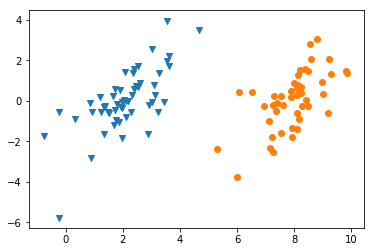

In [8]:
svm_model.draw(X_data,y_data)

In [ ]:
array1 = np.array([1,2,3,4,5])
array2 = np.array([[6,7],[7,8],[9,10],[1,2],[3,4]])
print np.array([array1[i]*array2[i] for i in range(len(array1))])